In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import torch
from transformers import AutoTokenizer, AutoModel

In [3]:
DEVICE = torch.device('cuda')

In [4]:
# Load the model and tokenizer
url = "microsoft/BiomedVLP-CXR-BERT-specialized"
tokenizer = AutoTokenizer.from_pretrained(url, trust_remote_code=True)
model = AutoModel.from_pretrained(url, trust_remote_code=True)

In [6]:
model.config

CXRBertConfig {
  "_name_or_path": "microsoft/BiomedVLP-CXR-BERT-specialized",
  "architectures": [
    "CXRBertModel"
  ],
  "attention_probs_dropout_prob": 0.25,
  "auto_map": {
    "AutoConfig": "microsoft/BiomedVLP-CXR-BERT-specialized--configuration_cxrbert.CXRBertConfig",
    "AutoModel": "microsoft/BiomedVLP-CXR-BERT-specialized--modeling_cxrbert.CXRBertModel"
  },
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.25,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "cxr-bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "projection_size": 128,
  "torch_dtype": "float32",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [11]:
from medvqa.utils.files import load_json
from medvqa.datasets.mimiccxr import MIMICCXR_CACHE_DIR
import os
reports = load_json(os.path.join(MIMICCXR_CACHE_DIR, 'background_findings_and_impression_20230612_174143.json'))

In [18]:
i_max = 0
len_max = 0
for i in range(len(reports)):
    if len(reports[i]['findings']) > len_max:
        len_max = len(reports[i]['findings'])
        i_max = i
i_max, len_max

(79893, 2453)

In [19]:
from nltk.
reports[i_max]
" ".join([reports[x]['findings'], reports[x]['impression']]

{'background': 'indication: year old man s/p readmission for sepsis // eval PA line.',
 'findings': '8:58 AM. An ET tube projects approximately 5.8 cm above the carina. Left subclavian central line projects over the mid SVC. A Swan-Ganz/PA catheter is seen in grossly appropriate location via the right IJ. The cardiac silhouette is enlarged. Bilateral hazy airspace opacities are consistent with pulmonary vascular congestion and severe pulmonary edema. Multifocal infection or pulmonary hemorrhage could also give this appearance. No pneumothorax. Difficult to exclude trace bilateral pleural effusions. WET READ VERSION #1 1:20 AM An ET tube projects approximately 5.8 cm above the carina. Left subclavian central line projects over the mid SVC. A Swan-Ganz/PA catheter is seen in grossly appropriate location via the right IJ. The cardiac silhouette is enlarged. Bilateral hazy airspace opacities are consistent with pulmonary vascular congestion and severe pulmonary edema. Multifocal infection 

In [7]:
x = 79893

# Input text prompts (e.g., reference, synonym, contradiction)
text_prompts = ["There is no pneumothorax or pleural effusion",
                "A sharply delineated triangular area of parenchymal consolidation is seen in the right upper lobe area laterally and posteriorly",
                "No pleural effusion or pneumothorax is seen",
                "The extent of the pleural effusion is constant.",
#                 " ".join([reports[x]['findings'], reports[x]['impression']]),
#                 reports[x]['impression'],
                """C/w CT , radiographs - bilateral pulmonary nodules consistent with metastatic disease - right sided pleural effusion and atelectasis, worse than on most recent examination - the esophagus is air filled and stomach is significantly distended with air - if there is concern for bowel obstruction given new nausea, dedicated abdominal films can be obtained - WET READ VERSION #1 7:22 AM C/w CT , radiographs - bilateral pulmonary nodules consistent with metastatic disease - right sided pleural effusion and atelectasis, worse than on most recent examination - the esophagus is air filled and stomach is significantly distended with air - if there is concern for bowel obstruction given new nausea, dedicated abdominal films can be obtained -.""",
                """J""",
               ]

# Tokenize and compute the sentence embeddings
tokenizer_output = tokenizer.batch_encode_plus(batch_text_or_text_pairs=text_prompts,
                                               add_special_tokens=True,
                                               padding='longest',
                                               return_tensors='pt')
embeddings = model.get_projected_text_embeddings(input_ids=tokenizer_output.input_ids,
                                                 attention_mask=tokenizer_output.attention_mask)

# Compute the cosine similarity of sentence embeddings obtained from input text prompts.
sim = torch.mm(embeddings, embeddings.t())

In [12]:
tokenizer_output = tokenizer.batch_encode_plus(batch_text_or_text_pairs=text_prompts,
                                               add_special_tokens=True,
                                               padding='longest',
                                               return_tensors='pt')


ValueError: You need to specify either `text` or `text_target`.

In [33]:
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
from medvqa.utils.files import read_lines_from_txt

In [30]:
from medvqa.metrics.medical.med_completeness import MEDICAL_TERMS_PATH

In [34]:
_medical_terms = set(read_lines_from_txt(MEDICAL_TERMS_PATH))

In [36]:
def _contains_medical_terms(text, k):
    count = 0
    for x in wordpunct_tokenize(text.lower()):
        if x in _medical_terms:
            count += 1
            if count >= k: return True
    return False

In [38]:
from tqdm import tqdm

In [39]:
sentences = set()
for r in tqdm(reports, total=len(reports), mininterval=2):
    impression = r['impression']
    findings = r['findings']
    if len(impression) > 0:
        for s in sent_tokenize(impression):
            if _contains_medical_terms(s, 1):
                sentences.add(s)
    if len(findings) > 0:
        for s in sent_tokenize(findings):
            if _contains_medical_terms(s, 1):
                sentences.add(s)

100%|███████████████████████████████████████████████████████████████████████████████████| 227835/227835 [00:58<00:00, 3889.83it/s]


In [42]:
sentences_list = list(sentences)

In [52]:
_contains_medical_terms("J.", 1)

True

In [51]:
min((len(x), x) for x in sentences_list)

(2, 'J.')

In [54]:
torch.mm(embeddings, embeddings.t())

tensor([[ 1.0000,  0.0961,  0.7456, -0.1916, -0.2685,  0.6406],
        [ 0.0961,  1.0000, -0.0081, -0.1407,  0.1197,  0.3077],
        [ 0.7456, -0.0081,  1.0000, -0.4709, -0.4241,  0.2662],
        [-0.1916, -0.1407, -0.4709,  1.0000,  0.7949,  0.1148],
        [-0.2685,  0.1197, -0.4241,  0.7949,  1.0000,  0.0034],
        [ 0.6406,  0.3077,  0.2662,  0.1148,  0.0034,  1.0000]],
       grad_fn=<MmBackward0>)

In [6]:
embeddings.shape

NameError: name 'embeddings' is not defined

In [24]:
text_prompts

['There is no pneumothorax or pleural effusion',
 'A sharply delineated triangular area of parenchymal consolidation is seen in the right upper lobe area laterally and posteriorly',
 'No pleural effusion or pneumothorax is seen',
 'The extent of the pleural effusion is constant.',
 'Upper zone redistribution, vascular plethora and blurring, and patchy bilateral airspace opacities, consistent with CHF and pulmonary edema. In the appropriate clinical setting, the differential diagnosis could include infection or hemorrhage. Evidence of prior surgery on the left, with pleural fluid and/or thickening at the left lung apex, similar to the prior study. Retrocardiac density again seen, consistent with left lower lobe collapse and/or consolidation and likely an element of left pleural fluid. Lines and tubes as described.']

In [16]:
sim

tensor([[ 1.0000,  0.0961,  0.7456, -0.1916,  0.5370],
        [ 0.0961,  1.0000, -0.0081, -0.1407,  0.3393],
        [ 0.7456, -0.0081,  1.0000, -0.4709,  0.6550],
        [-0.1916, -0.1407, -0.4709,  1.0000, -0.2170],
        [ 0.5370,  0.3393,  0.6550, -0.2170,  1.0000]], grad_fn=<MmBackward0>)

In [39]:
!python ../../scripts/mimiccxr/assign_cluster_ids_to_reports.py \
    --preprocessed_reports_filename "background_findings_and_impression_20230612_174143.json" \
    --batch_size 100 \
    --num_workers 4 \
    --num_processes 12 \
    --num_clusters 500 \
    --num_samples 50000

2023-06-16 06:46:38,570 - INFO - Loading preprocessed reports from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/background_findings_and_impression_20230612_174143.json
2023-06-16 06:46:40,453 - INFO - Loading report embeddings from /mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/report_embeddings(BiomedVLP-CXR-BERT-specialized,227835).pkl
2023-06-16 06:46:40,500 - INFO - Clustering 227835 report embeddings into 500 clusters
2023-06-16 06:46:40,500 - INFO - Sampling 50000 reports
2023-06-16 06:46:56,730 - INFO - labels.shape: (50000,)
2023-06-16 06:46:56,731 - INFO - X_cluster_centers.shape: (500, 128)
2023-06-16 06:46:56,731 - INFO - Finding the closest cluster center for each report
2023-06-16 06:49:18,709 - INFO - Finding the closest report to each cluster center
2023-06-16 06:49:35,334 - INFO - Saving report clusters to /mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/report_clusters(BiomedVLP-CXR-BERT-specialized,227835,500,50000).pkl


In [40]:
from medvqa.utils.files import load_pickle

report_clusters = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/report_clusters(BiomedVLP-CXR-BERT-specialized,227835,500,50000).pkl')

In [41]:
report_clusters.keys()

dict_keys(['X_cluster_centers', 'closest_cluster_centers_to_reports', 'closest_reports_to_cluster_centers'])

In [42]:
report_clusters['X_cluster_centers'].shape

(500, 128)

In [46]:
cluster_id_2_report_ids = [[] for _ in range(report_clusters['X_cluster_centers'].shape[0])]
for i, x in enumerate(report_clusters['closest_cluster_centers_to_reports']):
    cluster_id_2_report_ids[x].append(i)

In [50]:
from medvqa.utils.files import load_json

reports = load_json('/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/background_findings_and_impression_20230612_174143.json')

In [51]:
reports[cluster_id_2_report_ids[0][0]]

{'background': 'history: -year-old woman with acute shortness of breath now crackles, new from yesterday. Evaluate interval change.',
 'findings': 'AP chest compared to :. I do not see pulmonary edema. Moderate bilateral pleural effusion, left greater than right and bilateral infrahilar consolidation, left substantially greater than right, is all unchanged since . How much of the lower lobe abnormality is atelectasis and how much might be pneumonia is radiographically indeterminate. Heart size is top normal. There is no pneumothorax. Atherosclerotic calcification defines a normal caliber aorta. No pneumothorax. There is an enchondroma or infarct in the head of left humerus, clinically insignificant.',
 'impression': '',
 'path': '/mnt/data/mimic-cxr/files/p10/p10278322/s58456068.txt'}

In [58]:
reports[cluster_id_2_report_ids[1][6]]

{'background': 'indication: Dyspnea, shortness of breath. Evaluate for signs of volume overload.',
 'findings': 'Portable AP chest radiograph demonstrates a large right-sided pleural effusion with associated basilar atelectasis. Concurrent consolidation cannot be excluded. There is otherwise little change from . Left pectoral pacemaker leads are in stable position. There is no pneumothorax. There is no pulmonary edema. Evaluation of the heart size is limited due to low lung volumes and AP projection.',
 'impression': 'Enlarging right pleural effusion without pulmonary edema. Recommend obtaining PA and lateral chest radiograph.',
 'path': '/mnt/data/mimic-cxr/files/p10/p10013569/s57151026.txt'}

In [41]:
from medvqa.evaluation.plots import plot_embeddings_and_clusters

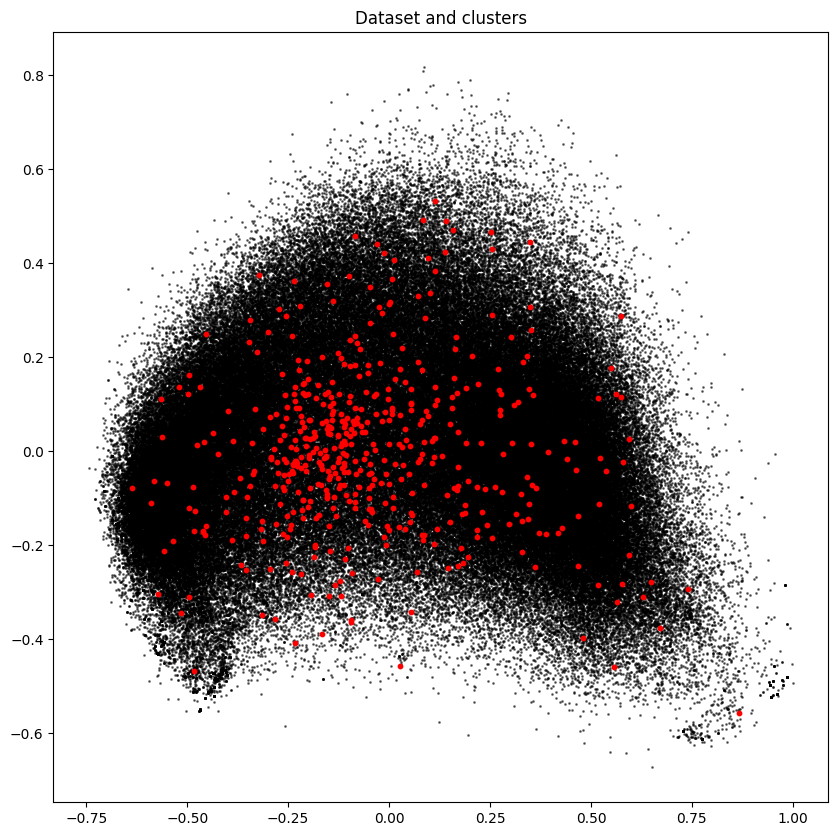

In [61]:
plot_embeddings_and_clusters(tmp, report_clusters['X_cluster_centers'])

In [17]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.4 MB/s eta 0:00:0000:01


In [5]:
from medvqa.utils.files import load_pickle

In [6]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/report_embeddings(BiomedVLP-CXR-BERT-specialized,227835).pkl')

In [60]:
tmp.shape

(227835, 128)

In [13]:
from sklearn.metrics.pairwise import pairwise_distances

In [1]:
from sklearn_extra.cluster import KMedoids

In [8]:
import random
subset_indices = random.sample(range(tmp.shape[0]), 10000)

In [10]:
X = tmp[subset_indices]
# X = tmp

In [11]:
X.shape

(10000, 128)

In [12]:
cobj = KMedoids(n_clusters=500, metric='cosine').fit(X)
labels = cobj.labels_

/home/pamessina/venv2/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 126 is empty! self.labels_[self.medoid_indices_[126]] may not be labeled with its corresponding cluster (126).
  warnings.warn(
/home/pamessina/venv2/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 184 is empty! self.labels_[self.medoid_indices_[184]] may not be labeled with its corresponding cluster (184).
  warnings.warn(


In [17]:
cobj.labels_.shape

(10000,)

In [19]:
cobj.cluster_centers_

array([[ 0.00094734,  0.03803842,  0.144283  , ..., -0.00345153,
        -0.016611  , -0.00623574],
       [ 0.05295038, -0.00884087,  0.20907874, ..., -0.05319765,
        -0.00115542, -0.04395712],
       [ 0.02228389,  0.01042967,  0.12213494, ..., -0.10647415,
        -0.03707173,  0.01239681],
       ...,
       [-0.02358292,  0.0643981 ,  0.01221653, ...,  0.01309107,
         0.04028616,  0.01940496],
       [-0.02717928, -0.03304156,  0.00340388, ...,  0.02165069,
         0.07684409,  0.0071563 ],
       [ 0.01011071, -0.01285446,  0.02324532, ..., -0.02852388,
         0.00078309,  0.00555548]], dtype=float32)

In [36]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

aux = cosine_similarity(X, cobj.cluster_centers_[0].reshape(1, -1))

In [37]:
np.argmax(aux)

890

In [38]:
aux[890]

array([1.], dtype=float32)

In [ ]:

/mnt/data/mimic-cxr/files/p10/p10060142/s52115374.txt

In [62]:
!ls /home/pamessina/medvqa-workspace/cache/mimiccxr/openai/

 gpt-3.5-turbo-0301_parsed_sentences.jsonl
 gpt-3.5-turbo_parsed_backgrounds.jsonl
 gpt-3.5-turbo_parsed_reports__backup.jsonl
 gpt-3.5-turbo_parsed_reports.jsonl
'gpt-3.5-turbo_parsed_reports(old).jsonl'
 gpt-3.5-turbo_parsed_sentences.jsonl
 gpt-4-0613_parsed_reports.jsonl
 gpt-4-0613_parsed_sentences.jsonl


In [82]:
!python ../../scripts/mimiccxr/assign_cluster_ids_to_facts.py \
    --integrated_sentence_facts_filepath "/home/pamessina/medvqa-workspace/cache/mimiccxr/integrated_sentence_facts(68493868,63886474).jsonl" \
    --batch_size 100 \
    --num_workers 4 \
    --num_processes 10 \
    --num_kmeans_clusters 1000 \
    --num_kmeans_iterations 300 \
    --num_samples_per_kmeans_cluster 50 \
    --num_kmedoids_clusters 1000

2023-06-26 20:26:53,822 - INFO - Loading facts from /home/pamessina/medvqa-workspace/cache/mimiccxr/integrated_sentence_facts(68493868,63886474).jsonl
2023-06-26 20:27:00,389 - INFO - Loaded 849523 sentences with facts
2023-06-26 20:27:02,104 - INFO - Loaded 414580 unique facts
2023-06-26 20:27:02,141 - INFO - Num of facts with freq >= 10: 21089
2023-06-26 20:27:02,177 - INFO - Num of facts with freq >= 100: 2722
2023-06-26 20:27:02,177 - INFO - Examples of facts:
2023-06-26 20:27:02,177 - INFO -     Wide involvement of the lungs (1)
2023-06-26 20:27:02,177 - INFO -     Left acute fractures (1)
2023-06-26 20:27:02,177 - INFO -     Coiled radioopaque material (2)
2023-06-26 20:27:02,177 - INFO -     Deep right costophrenic sulcus (1)
2023-06-26 20:27:02,177 - INFO -     Improvement in aeration at the left CP angle (1)
2023-06-26 20:27:02,261 - INFO - Facts embeddings already exist at /mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/fact_embeddings(BiomedVLP-CXR-BERT-specia

In [83]:
!ls -lh "/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/fact_kmedoids_clustering(BiomedVLP-CXR-BERT-specialized,414580,14145433,1000,1000,300,50).pkl"

-rw-rw-r-- 1 pamessina pamessina 8.1M Jun 26 20:34 '/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/fact_kmedoids_clustering(BiomedVLP-CXR-BERT-specialized,414580,14145433,1000,1000,300,50).pkl'


In [22]:
import medvqa
from importlib import reload

In [23]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

In [24]:
from medvqa.evaluation.plots import plot_embeddings
from medvqa.utils.files import load_pickle

In [28]:
fact_embeddings = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/fact_embeddings(BiomedVLP-CXR-BERT-specialized,414580,14145433).pkl')

In [49]:
fact_embeddings.keys()

dict_keys(['facts', 'embeddings'])

In [55]:
facts_kmeans_clustering = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/fact_kmeans_clustering(BiomedVLP-CXR-BERT-specialized,414580,14145433,1000,300).pkl')

In [29]:
fact_embeddings['embeddings'].shape

(414580, 128)

In [56]:
facts_kmeans_clustering.keys()

dict_keys(['cluster_ids', 'cluster_centers', 'closest_facts_to_cluster_centers'])

In [57]:
len(facts_kmeans_clustering['cluster_ids'])

414580

In [58]:
center_facts = [fact_embeddings['facts'][i] for i in facts_kmeans_clustering['closest_facts_to_cluster_centers']]

In [59]:
center_facts[:10]

['Bilateral aorticopulmonary window fullness',
 'Improving consolidations',
 'Less well defined mediastinal contours',
 'Side hole at the diaphragm hiatus',
 'Opacity in the setting of pneumonia',
 'Elevation of outer aspect of left hemidiaphragmatic contour',
 'Bilateral surgical clips',
 'Basal pleural drain',
 'Lead wire in the right atrium',
 'Lung hyperexpansion on frontal view']

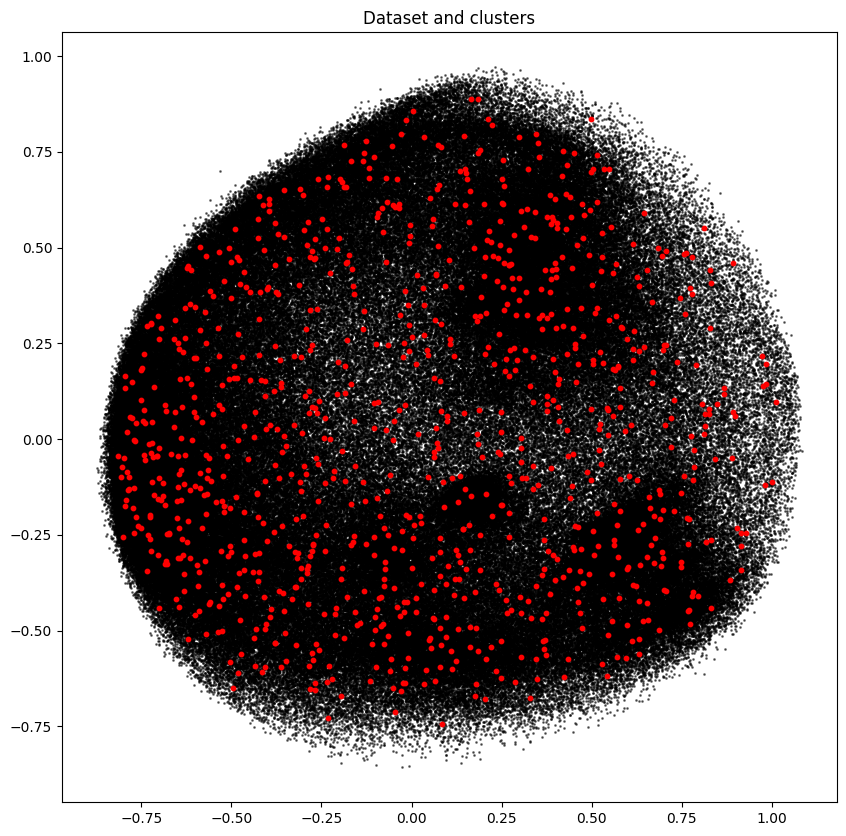

In [60]:
plot_embeddings_and_clusters(fact_embeddings['embeddings'], facts_kmeans_clustering['cluster_centers'])

In [61]:
from collections import Counter

In [134]:
cid2fids = {}
# for i, cid in enumerate(facts_kmeans_clustering['cluster_ids']):
for i, cid in enumerate(fact_kmedoids_clustering['closest_cluster_centers_to_facts']):
    try:
        cid2fids[cid].append(i)
    except KeyError:
        cid2fids[cid] = [i]

In [143]:
import random
cid = 100
fids = random.sample(cid2fids[cid], min(20, len(cid2fids[cid])))
for fid in fids:
    print(fact_embeddings['facts'][fid])

Traceable NG tube
Disting trachea
Traceable enteric tube
Flexed neck
Cuff overdistention
Tracheal rotation
Slightly shifted mediastinum to the right
Upper lobe distension
Bulbous
Partially obscured NG tube
Obscured right bronchus intermedius
Possibly in the distal esophagus
Opacity posterior to the carina
Chin overlying apex
Trauma board in place
Aspirated tooth
Nondistended upper stomach
Widening of the mediastinum to the right of midline
Chin overlying right upper lobe
Bilateral chin overlying lung apices


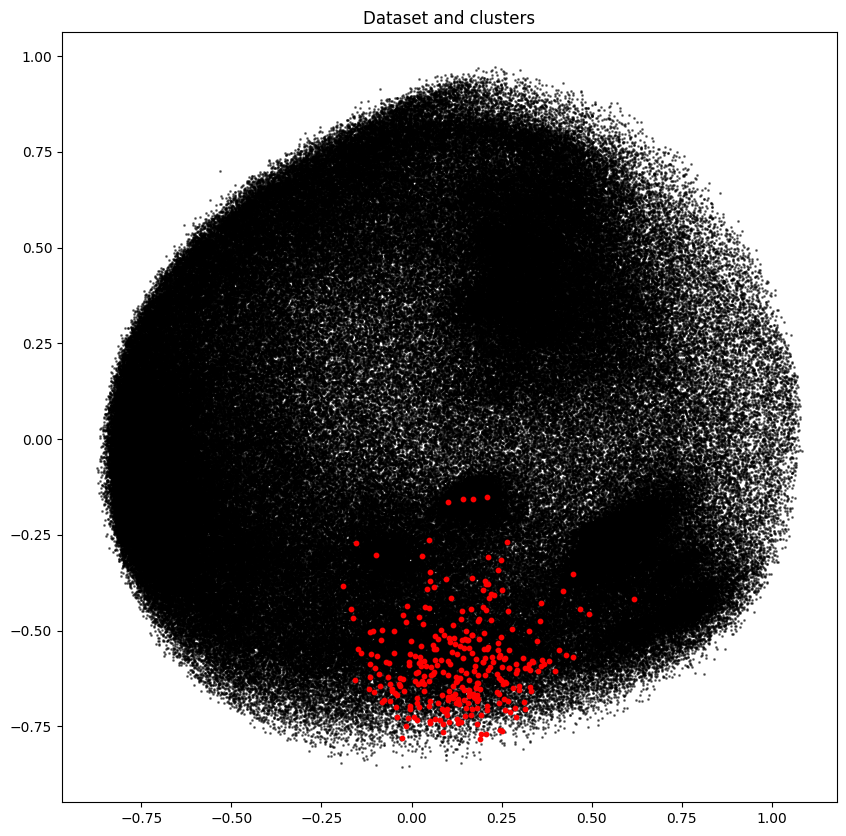

In [144]:
cluster_embeddings = fact_embeddings['embeddings'][cid2fids[cid]]
plot_embeddings_and_clusters(fact_embeddings['embeddings'], cluster_embeddings)

In [84]:
fact_kmedoids_clustering = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/cache/mimiccxr/fact_kmedoids_clustering(BiomedVLP-CXR-BERT-specialized,414580,14145433,1000,1000,300,50).pkl')

In [85]:
fact_kmedoids_clustering.keys()

dict_keys(['cluster_centers', 'closest_facts_to_cluster_centers', 'closest_cluster_centers_to_facts'])

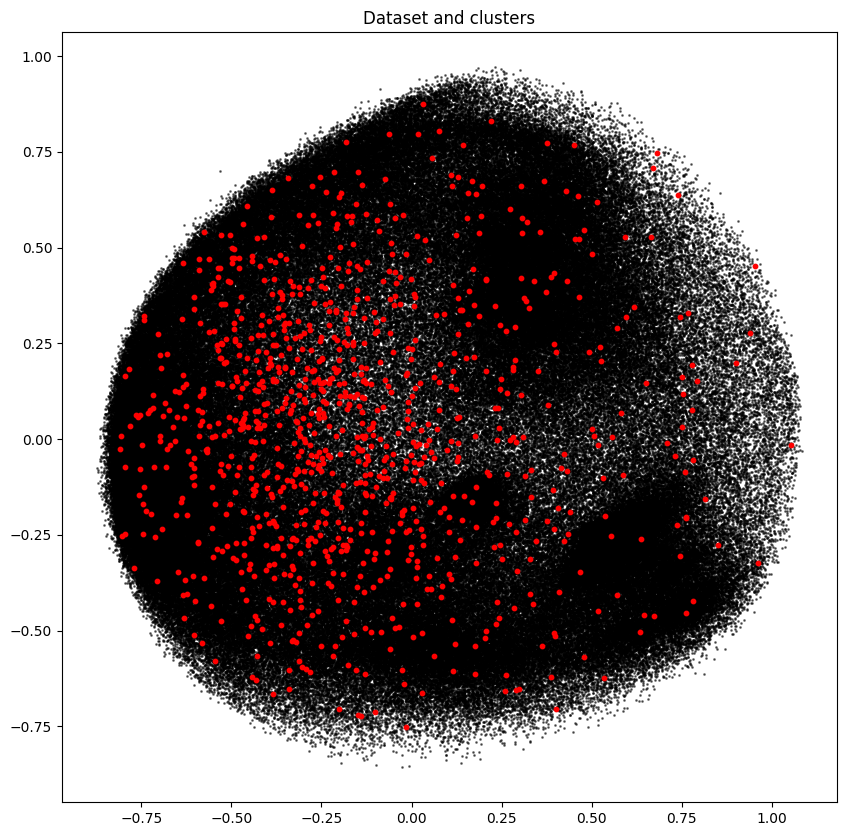

In [86]:
plot_embeddings_and_clusters(fact_embeddings['embeddings'], fact_kmedoids_clustering['cluster_centers'])

In [89]:
len(fact_kmedoids_clustering['closest_facts_to_cluster_centers'])

1000

In [90]:
center_facts = [fact_embeddings['facts'][i] for i in fact_kmedoids_clustering['closest_facts_to_cluster_centers']]

In [91]:
center_facts[:20]

['Inferior portion of fixation hardware',
 'Surgical sutures in the right lung apex',
 'Linear density in left lung base',
 'Overlapping left scapula',
 'Stent projecting over the left lower lobe',
 'Very small left effusion',
 'Density in left humerus',
 'Linear opacities in left lung',
 'Fractures of the second sternal wire',
 'Small lesions in the right upper lobe',
 'Less apparent left base opacity',
 'Posterior costophrenic sulcus density',
 'Left mid lung field atelectasis',
 'Consultation of CTA',
 'Calcifications in the lower mediastinum',
 'Thoracic spine stabilization rods',
 'Less pronounced interstitial markings',
 'Superimposition of vessels',
 'New cervical spine surgical hardware',
 'Fixation devices on upper lumbar spine']

In [95]:
cid2fids = {}
for i, cid in enumerate(fact_kmedoids_clustering['closest_cluster_centers_to_facts']):
    try:
        cid2fids[cid].append(i)
    except KeyError:
        cid2fids[cid] = [i]

In [96]:
Counter(fact_kmedoids_clustering['closest_cluster_centers_to_facts'])

Counter({966: 233,
         254: 1311,
         159: 23,
         285: 138,
         269: 1526,
         720: 413,
         407: 392,
         292: 1078,
         272: 1249,
         643: 916,
         962: 879,
         552: 557,
         954: 1698,
         518: 196,
         959: 640,
         975: 1475,
         850: 1516,
         246: 1229,
         590: 1110,
         596: 702,
         674: 2197,
         917: 484,
         334: 1873,
         911: 31180,
         849: 3520,
         200: 607,
         539: 775,
         691: 1254,
         930: 1913,
         9: 1103,
         345: 1608,
         357: 4302,
         221: 2735,
         390: 613,
         871: 1394,
         265: 1043,
         945: 1198,
         439: 126,
         177: 291,
         449: 127,
         772: 595,
         464: 514,
         996: 8697,
         657: 4101,
         967: 5404,
         946: 766,
         838: 328,
         32: 1895,
         678: 4074,
         146: 1457,
         491: 1146,
     

In [101]:
import random
cid = 1
fids = random.sample(cid2fids[cid], 30)
for fid in fids:
    print(fact_embeddings['facts'][fid])

Right apex cystic lucencies
Surgical chain sutures in the right upper lung field
Osseous density in lateral right hemithorax tracts
Right paramediastinal soft tissue density structures
Suture projecting over the right mid lung
Old scar at the right lung apex
Sutures in the right midlung
Unchanged right apical thickening
Right paramediastinal clips
Known right breast surgery
Surgical clips in right lower hemithorax
Right apical pleural thickening
1.8 cm to 3.5 cm in diameter
Surgical clips in the right lower lung
Radiodense marker in the right upper lung
Surgical clips in right mid lung region
Sutures chains in the right midlung
Chronic right apex atelectasis
Scar at the right lung apex
Nodular pleural thickening at right lung apex
Right breast density
Right apic scarring
Chain sutures in the right apical region
Severe apical thickening
Right upper paramediastinal scarring
Sutures overlying the right upper-to-mid hemithorax
Right bi-apical pleuroparenchymal scarring
Right paramediastina

In [104]:
reload(medvqa.utils.math)

<module 'medvqa.utils.math' from '/home/pamessina/medvqa/medvqa/utils/math.py'>

In [110]:
from medvqa.utils.math import rank_vectors_by_consine_similarity

cid = 300
fids = cid2fids[cid]
fid = random.choice(fids)
cluster_embeddings = fact_embeddings['embeddings'][fids]
query_embedding = fact_embeddings['embeddings'][fid]

ranked_indices = rank_vectors_by_consine_similarity(cluster_embeddings, query_embedding)

print(fact_embeddings['facts'][fid])
print('----')

for i in ranked_indices:
    print(fact_embeddings['facts'][fids[i]])

Both clavicles fracture
----
Both clavicles fracture
Both clavicle fractures
Unchanged clavicular fractures
Recent clavicular fracture
Clavicular fracture line
Multiple clavicle fractures
Cortical step-off
Lower sternum breaks
Presence of scapular fracture
Bilateral clavicle fractures
Bilateral fractures through the most inferior pedicle screws
Large bilateral cervical ribs
Unchanged scapular fracture
Likely post-operative fracture
Bilateral clavicular fractures
Interval upper rib fractures
Multiple upper ribs
Broken clavicle
Posttraumatic shin
Mesh material projecting over diaphragmatic contour
Gas-containing pseudocyst
Multiple rounded opacities in left mid abdomen
Obscured cavicular fracuture
Large cervical ribs
Pronounced sternum fracture
Epidural hematoma


In [158]:
from medvqa.utils.math import rank_vectors_by_consine_similarity

query_idx = random.choice(range(fact_embeddings['embeddings'].shape[0]))
query_embedding = fact_embeddings['embeddings'][query_idx]
ranked_indices = rank_vectors_by_consine_similarity(fact_embeddings['embeddings'], query_embedding)

print(query_idx)
print(fact_embeddings['facts'][query_idx])
print('----')

for j, i in enumerate(ranked_indices):
    print(fact_embeddings['facts'][i])
    if j > 20:
        break

193111
Enlargement accentuated by portable technique
----
Enlargement accentuated by portable technique
Enlarged cardiac silhouette due to portable technique
Cardiac silhouette enlargement due to portable technique
Enlarged cardiac size due to portable technique
Enlargement accentuated by AP technique
Cardiomegaly accentuated by portable AP technique
Enlarged cardiac silhouette due to positioning
Cardiomegaly due to portable technique
Cardiac enlargement likely accentuated by portable technique
Cardiac enlargement accentuated by lordotic positioning
Enlarged cardiac silhouette accentuated by portable radiograph technique
Enlargement likely accentuated by AP portable technique
Enlarged heart size due to portable technique
Marked mediastinal venous enlargement
Enlarged cardiac silhouette accentuated by portable technique
Cardiomegaly related to AP technique
Enlarged heart allotting for portable technique
Cardiac silhouette allowing for patient rotation
Enlarged heart due to patient posit

In [111]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

def sort_sentences(sentences):
    tokenized_sentences = [word_tokenize(x) for x in tqdm(sentences, mininterval=2)]
    vocab_freq = dict()        
    for tokens in tqdm(tokenized_sentences, mininterval=2):
        for word in tokens:
            vocab_freq[word] = vocab_freq.get(word, 0) + 1
    def _difficulty(i):
        return sum(1 / vocab_freq[word] for word in tokenized_sentences[i])
    ranked_indices = sorted(range(len(tokenized_sentences)), key=_difficulty, reverse=True)
    ranked_sentences = [sentences[i] for i in ranked_indices]
    return ranked_sentences

In [112]:
sorted_facts = sort_sentences(fact_embeddings['facts'])

100%|█████████████████████████████████████████████████████████████████████████████████| 414580/414580 [00:00<00:00, 430845.77it/s]


In [115]:
sorted_facts[20000:20000 + 50]

['Upper-lobe predominant pattern',
 'Decrease in striated lucencies',
 'Decreased pneumomediastinal air compared with prior film',
 'Edema toe thorax',
 'Residual contrast at the level of the diaphragmatic crus',
 'Radioopacity at the level of the anterior interspace',
 'Repositioning under fluoroscopic guidance',
 'Tip of NG tube escapes lower edge of image',
 'Known carcinoid pulmonary metastasis',
 'Another forms of interstitial infiltrate',
 'Feeding tube touching the greater curvature of the stomach',
 'Probablely taken at different points in time',
 'Saber sheath trachea configuration',
 'Left generally directed chest tube',
 'Three pills lodged in the esophagus',
 'Three pills lodged in esophagus',
 'Core-valve prosthesis',
 'Opacity likely relates to osseous deformity',
 'Transthoracic needle aspiration',
 'Possibly compatible with lacerations',
 'Emphysema spreading below the diaphragm',
 'Orogastric-type tubes beneath diaphragm',
 'New history of leukemia',
 'Left lower lobe 

In [116]:
import re
_VALID_JSON_OBJECT_REGEX = re.compile(r"\{\s*\"location\"\s*:\s*\"[^\"]*\"\s*,\s*\"specific\"\s*:\s*\"[^\"]*\"\s*,\s*\"general\"\s*:\s*\"[^\"]*\"\s*\}")

In [128]:
_VALID_JSON_OBJECT_REGEX.search("""
asdfasdfasd {
"location": "left wall of trachea"  ,
"specific": "tracheostomy tube angled",
"general": "tracheostomy tube"
}
""").group()

'{\n"location": "left wall of trachea"  ,\n"specific": "tracheostomy tube angled",\n"general": "tracheostomy tube"\n}'

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel
from medvqa.models.checkpoint import get_checkpoint_filepath
from medvqa.models.common import load_model_state_dict
from medvqa.models.huggingface_utils import _adapt_checkpoint_keys

In [3]:
DEVICE = torch.device('cuda')

In [4]:
# Load the model and tokenizer
url = "microsoft/BiomedVLP-CXR-BERT-specialized"
tokenizer = AutoTokenizer.from_pretrained(url, trust_remote_code=True)
model = AutoModel.from_pretrained(url, trust_remote_code=True)

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


In [7]:
chekpoint_filepath = get_checkpoint_filepath('/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20240207_184445_MIMIC-CXR(triplets+classif+entcont+nli+radgraph+autoencoder)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)')
chekpoint_filepath

checkpoint_names = ['checkpoint_91_cacc+chf1+chf1+cscc+encc+hscc+nlcc+sass+spss+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9337.pt']


'/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20240207_184445_MIMIC-CXR(triplets+classif+entcont+nli+radgraph+autoencoder)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/checkpoint_91_cacc+chf1+chf1+cscc+encc+hscc+nlcc+sass+spss+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9337.pt'

In [8]:
tmp = torch.load(chekpoint_filepath)

In [14]:
load_model_state_dict(model, _adapt_checkpoint_keys(tmp['model']))

Examples of keys in loaded state dict but not in model:
  chest_imagenome_anatloc_classifier.bias
  health_status_classifier.weight
  health_status_classifier.bias
  fact_decoder.decoder.layers.0.self_attn.out_proj.bias
  chest_imagenome_anatloc_classifier.weight
  fact_decoder.decoder.layers.0.norm3.weight
  spert_size_embeddings.weight
  fact_decoder.decoder.layers.0.self_attn.in_proj_bias
  fact_decoder.decoder.layers.0.linear2.bias
  fact_decoder.decoder.layers.0.multihead_attn.out_proj.weight


In [15]:
torch.save(model.state_dict(), '/home/pamessina/public_model_weights/CXRFE(T+C+EC+NLI+ER+SD).pt')

In [16]:
chekpoint_filepath = get_checkpoint_filepath('/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20240129_151525_MIMIC-CXR(triplets+classif+entcont+nli+autoencoder)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)')
print(chekpoint_filepath)
tmp = torch.load(chekpoint_filepath)
load_model_state_dict(model, _adapt_checkpoint_keys(tmp['model']))
torch.save(model.state_dict(), '/home/pamessina/public_model_weights/CXRFE(T+C+EC+NLI+SD).pt')

checkpoint_names = ['checkpoint_98_cacc+chf1+chf1+cscc+encc+hscc+nlcc+sass+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9322.pt']
/mnt/data/pamessina/workspaces/medvqa-workspace/models/fact_embedding/20240129_151525_MIMIC-CXR(triplets+classif+entcont+nli+autoencoder)_FactEncoder(microsoft-BiomedVLP-CXR-BERT-specialized)/checkpoint_98_cacc+chf1+chf1+cscc+encc+hscc+nlcc+sass+ta0)+ta1)+ta2)+ta0)+ta1)+ta2)+ta3)+ta4)+ta5)+ta6)+ta7)=0.9322.pt
Examples of keys in loaded state dict but not in model:
  fact_decoder.decoder.layers.0.self_attn.in_proj_bias
  fact_decoder.decoder.layers.0.self_attn.in_proj_weight
  chest_imagenome_anatloc_classifier.bias
  fact_decoder.decoder.layers.0.multihead_attn.out_proj.weight
  nli_classifier.weight
  comparison_status_classifier.weight
  health_status_classifier.weight
  fact_decoder_input_layer.bias
  category_classifier.bias
  fact_decoder.W_vocab.bias
